In [80]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# Download NLTK data files (only need to run once)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Martim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Martim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Martim\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Martim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [81]:
df_true = pd.read_csv('true.csv')
df_true['label'] = 0
df_true.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [82]:
df_fake = pd.read_csv('fake.csv')
df_fake['label'] = 1
df_fake.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [83]:
main_df = pd.concat([df_true, df_fake], ignore_index=True)
main_df = main_df.sample(frac=1).reset_index(drop=True)
main_df.shape

(44898, 5)

In [84]:
main_df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [86]:
len(main_df[main_df['text'] == ' '])

627

In [87]:
main_df = main_df[main_df['text'] != ' ']
main_df.shape

(44271, 5)

In [88]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44271 entries, 1 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44271 non-null  object
 1   text     44271 non-null  object
 2   subject  44271 non-null  object
 3   date     44271 non-null  object
 4   label    44271 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.0+ MB


In [89]:
main_df['subject'].value_counts()

subject
politicsNews       11271
worldnews          10145
News                9050
politics            6435
left-news           4310
Government News     1499
US_News              783
Middle-east          778
Name: count, dtype: int64

In [90]:
def text_processing(text):
    text = text.lower()
    text = word_tokenize(text)
    
    tokens = [word for word in text if word not in string.punctuation]

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [91]:
main_df['text_processed'] = main_df['text'].apply(text_processing)
main_df.head()

,title,text,subject,date,label,text_processed
1,"BREAKING: Democrat Congressman, Vocal ILLEGAL ...","Rep. Luis Guti rrez (Ill.), one of the most vo...",politics,"Nov 27, 2017",1,rep. luis guti rrez ill. one vocal immigration...
2,OBAMA’S EMBARRASSING Farewell Interview: Mom W...,We all know the rules are a little different f...,politics,"Dec 26, 2016",1,know rule little different political class mic...
3,GOP Congresswoman Destroyed In Her Own Poll O...,Republican Congresswoman Marsha Blackburn (TN)...,News,"January 4, 2017",1,republican congresswoman marsha blackburn tn d...
4,Obama’s Christmas In Hawaii To Cost Taxpayers ...,Judicial Watch has been the one organization t...,Government News,"Dec 15, 2015",1,judicial watch one organization reporting craz...
5,"Republican Scalise undergoes surgery, in fair ...",WASHINGTON (Reuters) - U.S. Representative Ste...,politicsNews,"July 13, 2017",0,washington reuters u.s. representative steve s...


In [92]:
fake_news = main_df[main_df['label'] == 1]['text_processed']

vectorizer = CountVectorizer(max_features=20, stop_words='english')
word_count_matrix = vectorizer.fit_transform(fake_news)

word_frequencies = word_count_matrix.sum(axis=0).tolist()[0]
words = vectorizer.get_feature_names_out()

word_freq_df = pd.DataFrame({'word': words, 'frequency': word_frequencies})
word_freq_df = word_freq_df.sort_values(by='frequency', ascending=False)

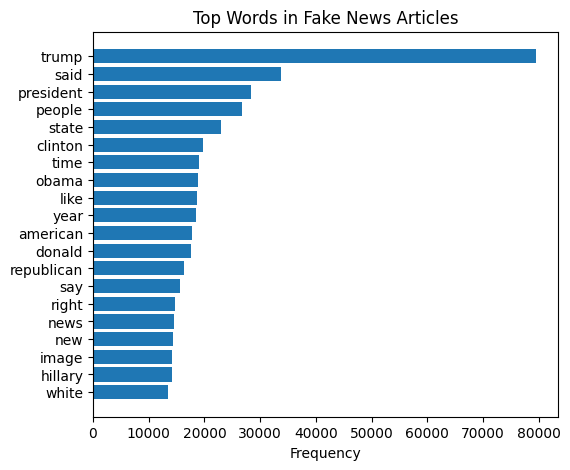

In [93]:
plt.figure(figsize=(6, 5))
plt.barh(word_freq_df['word'], word_freq_df['frequency'], align='center')
plt.xlabel('Frequency')
plt.title('Top Words in Fake News Articles')
plt.gca().invert_yaxis()
plt.show()

In [94]:
X = main_df['text_processed']
y = main_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [95]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [97]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

print("Classification Report:\n", classification_report(y_test, y_pred))

scores = cross_val_score(model, X_train_tfidf, y_train, cv=5)
print(f"Cross-validation accuracy: {scores.mean():.4f}")

Confusion Matrix:
 [[4233   58]
 [  74 4490]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      4291
           1       0.99      0.98      0.99      4564

    accuracy                           0.99      8855
   macro avg       0.99      0.99      0.99      8855
weighted avg       0.99      0.99      0.99      8855

Cross-validation accuracy: 0.9830
